In [1]:
import pymongo as pmg
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from KRData.HKData import HKFuture
import configparser

In [8]:
conf_parser = configparser.ConfigParser()
conf_parser.read( 'conf.ini')
mg_host = conf_parser.get('MGDB', 'host')
mg_user = conf_parser.get('MGDB', 'user')
mg_password = conf_parser.get('MGDB', 'password')
hk=HKFuture(pwd=mg_password,host=mg_host,user=mg_user)
begin='2014-01-01'
dt1=dt.datetime.now()
_fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol']
df1=hk.get_main_contract_bars('HSI', _fields, begin)


print(dt.datetime.now()-dt1)

0:00:48.161755


In [2]:
# df1.to_pickle("pkl/hsi.pkl")
df1=pd.read_pickle("pkl/hsi.pkl")

In [3]:
# df2.datetime.apply(lambda x:x.time())
time1=dt.time(9,15,0)
time2=dt.time(16,30,0)
newDF=df1[(df1.datetime.dt.time>=time1)&(df1.datetime.dt.time<=time2)]

In [36]:
def Calc(date1):
#     date1='2014-01-02'
    D1=newDF[str(date1)]
    O=D1.iloc[0]['close']
    C=D1.iloc[-1]['close']
    H=D1['close'].max()
    L=D1['close'].min()
    Hi=D1['high'].idxmax().time()
    Li=D1['low'].idxmin().time()
    res={}
    res['Date']=date1
    res['State']=0
    res['Open']=O
    res['High']=H
    res['Low']=L
    res['Close']=C
    res['Hi']=Hi
    res['Li']=Li
    
    H1=D1[:60]['close'].max()
    L1=D1[:60]['close'].min()
    res['High1']=H1
    res['Low1']=L1
    

#state[1:多，3多赚，5多亏，7多止损，2空，4空赚，6空亏，8空止损]
#     print(H1,L1,H1-L1)
    H2=0      #成交后的最高价
    L2=50000     #成交后的最低价
    Stop=(H1-L1)*0.5
    if Stop<40:
        Stop=40
    if Stop>220:
        Stop=220
    StopGo=True
    for row in D1[60:].iterrows():
        close=row[1]['close']
        if res['State']==1 or res['State']==2:
            H2=close if close>H2 else H2
            L2=close if close<L2 else L2
            cont1=res['State']==1 and close<res['Price']-Stop and StopGo
            cont2=res['State']==2 and close>res['Price']+Stop and StopGo
            if cont1 :
                res['StopPrice']=close
                StopGo=False
                res['State']=7 #多上损：
                res['Diff_S']=close-res['Price']-1
            elif cont2:
                res['StopPrice']=close
                StopGo=False
                res['State']=8 #空上损：
                res['Diff_S']=res['Price']-close-1
        elif (close>H1 or close<L1) and res['State']==0:
            res['Price']=close
            res['Ref']=row[0]
            if close>H1:
                res['Diff']=res['Close']-res['Price']-1
                res['State']=1
            else:
                res['Diff']=res['Price']-res['Close']-1
                res['State']=2
            res['Diff_S']=res['Diff']
                
    if StopGo and res['State']==1:
        res['State']=3 if res['Diff']>0 else 5
    elif StopGo and res['State']==2:
        res['State']=4 if res['Diff']>0 else 6
            
            
    res['High2']=H2
    res['Low2']=L2
    return res

print("OK")

OK


In [37]:
Data=[]
dl=newDF.datetime.dt.date.unique()
for dd in dl:
    Data.append(Calc(dd))
    
print(len(Data))

F1=pd.DataFrame(Data)
F1['Date']=pd.to_datetime(F1.Date)
F1.set_index('Date',inplace=True)

F1['Diff_L']=F1.apply(lambda x:x.Low2-x.Price if x['State']% 2==1 else x.Price-x.High2 ,axis=1) 
F1['Diff_H']=F1.apply(lambda x:x.High2-x.Price if x['State']% 2==0 else x.Price-x.Low2 ,axis=1)
F1['Diff_W']=F1['High1']-F1['Low1']
F1['HiH']=F1.Hi.apply(lambda x:x.hour)
F1['LiH']=F1.Li.apply(lambda x:x.hour)
F1['HiM']=F1.Hi.apply(lambda x:(x.hour*60+x.minute-540-14)//60)
F1['LiM']=F1.Li.apply(lambda x:(x.hour*60+x.minute-540-14)//60)
# F1['Win1']=F1[F1.Diff_S>0]['Diff_S']
# F1['Lose1']=F1[F1.Diff_S<0]['Diff_S']
cols=['Diff_S','Diff','Diff_L','Diff_H','Diff_W']
CalcList=['mean','sum','max','min','count']
F1.head(5)

1270


,Close,Diff,Diff_S,Hi,High,High1,High2,Li,Low,Low1,...,Ref,State,StopPrice,Diff_L,Diff_H,Diff_W,HiH,LiH,HiM,LiM
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,23334.0,-45.0,-45.0,09:30:00,23485.0,23485.0,23377.0,11:25:00,23184.0,23299.0,...,2014-01-02 10:36:00,6,NaN,-87.0,87.0,186.0,9,11,0,2
2014-01-03,22790.0,105.0,105.0,09:15:00,23137.0,23137.0,22923.0,15:43:00,22759.0,22902.0,...,2014-01-03 10:20:00,4,NaN,-27.0,27.0,235.0,9,15,0,6
2014-01-06,22679.0,NaN,NaN,09:15:00,22773.0,22773.0,0.0,09:45:00,22563.0,22563.0,...,NaT,0,NaN,NaN,NaN,210.0,9,9,0,0
2014-01-07,22612.0,-151.0,-73.0,10:39:00,22775.0,22744.0,22775.0,09:17:00,22609.0,22609.0,...,2014-01-07 10:37:00,7,22690.0,-72.0,72.0,135.0,10,9,1,0
2014-01-08,22944.0,18.0,18.0,13:07:00,23047.0,22909.0,23047.0,09:15:00,22729.0,22729.0,...,2014-01-08 13:01:00,3,NaN,-5.0,5.0,180.0,13,9,3,0


In [39]:
col2=['Close','State','Diff','Diff_S','Diff_L','Diff_H']
dd={
    'Close':['count'],
    'Diff_S':['sum','mean'],
    'Diff':['sum','mean'],

}
F1[col2].groupby([F1.index.year,'State']).agg(dd)
# F1[col2].groupby(F1.index.year).agg(dd)

Close   Diff_S                 Diff            
           count      sum        mean      sum        mean
Date State                                                
2014 0        24      0.0         NaN      0.0         NaN
     3        39   4104.0  105.230769   4104.0  105.230769
     4        42   4893.0  116.500000   4893.0  116.500000
     5        15   -535.0  -35.666667   -535.0  -35.666667
     6        18   -619.0  -34.388889   -619.0  -34.388889
     7        48  -3254.0  -67.791667  -3326.0  -69.291667
     8        61  -4348.0  -71.278689  -5316.0  -87.147541
2015 0        16      0.0         NaN      0.0         NaN
     3        42   5398.0  128.523810   5398.0  128.523810
     4        47   6852.0  145.787234   6852.0  145.787234
     5        12   -585.0  -48.750000   -585.0  -48.750000
     6        12   -483.0  -40.250000   -483.0  -40.250000
     7        66  -6816.0 -103.272727  -7368.0 -111.636364
     8        52  -4442.0  -85.423077  -4416.0  -84.923077
2016 0        15      0.0         NaN      0.0         NaN
     3        46   4158.0   90.391304   4158.0   90.391304
     4        43   4311.0  100.255814   4311.0  100.255814
     5        17   -494.0  -29.058824   -494.0  -29.058824
     6        22   -698.0  -31.727273   -698.0  -31.727273
     7        47  -3674.0  -78.170213  -4029.0  -85.723404
     8        55  -3996.0  -72.654545  -4173.0  -75.872727
2017 0        29      0.0         NaN      0.0         NaN
     3        53   5053.0   95.339623   5053.0   95.339623
     4        32   3488.0  109.000000   3488.0  109.000000
     5        15   -356.0  -23.733333   -356.0  -23.733333
     6        21   -755.0  -35.952381   -755.0  -35.952381
     7        41  -2754.0  -67.170732  -2329.0  -56.804878
     8        55  -4009.0  -72.890909  -5181.0  -94.200000
2018 0        10      0.0         NaN      0.0         NaN
     3        48   7048.0  146.833333   7048.0  146.833333
     4        54  10185.0  188.611111  10185.0  188.611111
     5        15   -723.0  -48.200000   -723.0  -48.200000
     6        13   -397.0  -30.538462   -397.0  -30.538462
     7        47  -4996.0 -106.297872  -4842.0 -103.021277
     8        59  -6658.0 -112.847458  -7274.0 -123.288136
2019 0         4      0.0         NaN      0.0         NaN
     3        12   1853.0  154.416667   1853.0  154.416667
     4         5    530.0  106.000000    530.0  106.000000
     5         3    -72.0  -24.000000    -72.0  -24.000000
     6         4   -126.0  -31.500000   -126.0  -31.500000
     7         6   -708.0 -118.000000   -801.0 -133.500000
     8         5   -462.0  -92.400000   -465.0  -93.000000

In [547]:
cols=['Diff_S','Diff','Diff_W','Win','Lose','Stop','Win1','Lose1']
dd={
    'Diff_S':['count','mean','sum','max','min','std'],
    'Diff':['mean'],
    'Diff_W':['mean'],
    'Win':['sum','mean'],
    'Lose':['sum','mean'],
    'Stop':['sum','mean','max'],
    'Win1':['sum','mean'],
    'Lose1':['sum','mean']
}
F1[cols].resample('A').agg(dd)

Diff_S                                                    Diff  \
            count       mean     sum    max    min         std       mean   
Date                                                                        
2014-12-31    223   0.309417    69.0  385.0 -156.0  103.329606  -2.582960   
2015-12-31    231  -0.904762  -209.0  556.0 -395.0  144.538725  -1.606061   
2016-12-31    230  -1.021739  -235.0  375.0 -143.0   99.130695  -3.021739   
2017-12-31    217   4.539171   985.0  568.0 -192.0  106.140497   0.631336   
2018-12-31    236  19.474576  4596.0  934.0 -255.0  170.846190  17.936441   
2019-12-31     35  29.800000  1043.0  375.0 -158.0  133.399841  27.257143   

                Diff_W    Win             Lose             Stop            \
                  mean    sum      mean    sum      mean    sum mean  max   
Date                                                                        
2014-12-31  142.340081   83.0  0.372197  140.0  0.627803   96.0  1.0  1.0   
2015-12-31  195.352227   90.0  0.389610  141.0  0.610390  114.0  1.0  1.0   
2016-12-31  157.167347   93.0  0.404348  137.0  0.595652   94.0  1.0  1.0   
2017-12-31  137.500000   91.0  0.419355  126.0  0.580645   80.0  1.0  1.0   
2018-12-31  221.272358  102.0  0.432203  134.0  0.567797  106.0  1.0  1.0   
2019-12-31  211.846154   17.0  0.485714   18.0  0.514286   11.0  1.0  1.0   

               Win1                Lose1             
                sum        mean      sum       mean  
Date                                                 
2014-12-31   9094.0  109.566265  -9025.0 -64.464286  
2015-12-31  12374.0  137.488889 -12583.0 -89.241135  
2016-12-31   8728.0   93.849462  -8963.0 -65.423358  
2017-12-31   8718.0   95.802198  -7733.0 -61.373016  
2018-12-31  17335.0  169.950980 -12739.0 -95.781955  
2019-12-31   2400.0  141.176471  -1357.0 -75.388889

In [601]:
F1.Diff_S.sum()

7085.0

In [577]:
F1['W1']=F1.Diff_W//50
cols=['W1','Diff_S','Diff','Diff_W','Win','Lose','Stop','Win1','Lose1']
F1[cols].groupby('W1').agg(['sum','count','mean'])

Diff_S                      Diff                     Diff_W        \
         sum count        mean     sum count        mean      sum count   
W1                                                                        
0.0     79.0     2   39.500000   223.0     2  111.500000     87.0     2   
1.0    717.0   217    3.304147  -390.0   217   -1.797235  19052.0   230   
2.0   1842.0   359    5.130919  2474.0   359    6.891365  47779.0   385   
3.0   2713.0   272    9.974265  2713.0   272    9.974265  50025.0   292   
4.0    887.0   170    5.217647  -932.0   170   -5.482353  41434.0   187   
5.0    424.0    65    6.523077    78.0    65    1.200000  21266.0    79   
6.0     88.0    37    2.378378  -148.0    37   -4.000000  13149.0    41   
7.0    135.0    17    7.941176   -38.0    17   -2.235294   6690.0    18   
8.0   -341.0    16  -21.312500  -185.0    16  -11.562500   7104.0    17   
9.0     96.0     7   13.714286  -559.0     7  -79.857143   3276.0     7   
10.0   276.0     3   92.000000   276.0     3   92.000000   2087.0     4   
11.0   -64.0     2  -32.000000  -157.0     2  -78.500000   1149.0     2   
13.0    -1.0     1   -1.000000    -1.0     1   -1.000000    663.0     1   
14.0   604.0     2  302.000000   604.0     2  302.000000   1477.0     2   
15.0  -395.0     1 -395.000000  -166.0     1 -166.000000    753.0     1   
23.0     0.0     0         NaN     0.0     0         NaN   1191.0     1   
25.0  -110.0     1 -110.000000  -110.0     1 -110.000000   1254.0     1   

                     Win     ...          Lose   Stop                Win1  \
             mean    sum     ...          mean    sum count mean      sum   
W1                           ...                                            
0.0     43.500000    1.0     ...      0.500000    1.0     1  1.0    130.0   
1.0     82.834783   75.0     ...      0.654378  126.0   126  1.0   7121.0   
2.0    124.101299  134.0     ...      0.626741  186.0   186  1.0  15466.0   
3.0    171.318493  116.0     ...      0.573529  118.0   118  1.0  15040.0   
4.0    221.572193   72.0     ...      0.576471   62.0    62  1.0   9554.0   
5.0    269.189873   27.0     ...      0.584615   27.0    27  1.0   4892.0   
6.0    320.707317   17.0     ...      0.540541    8.0     8  1.0   2004.0   
7.0    371.666667    9.0     ...      0.470588    4.0     4  1.0   1079.0   
8.0    417.882353    7.0     ...      0.562500    4.0     4  1.0   1010.0   
9.0    468.000000    3.0     ...      0.571429    3.0     3  1.0    859.0   
10.0   521.750000    2.0     ...      0.333333    0.0     0  NaN    353.0   
11.0   574.500000    1.0     ...      0.500000    1.0     1  1.0    227.0   
13.0   663.000000    0.0     ...      1.000000    0.0     0  NaN      0.0   
14.0   738.500000    2.0     ...      0.000000    0.0     0  NaN    604.0   
15.0   753.000000    0.0     ...      1.000000    1.0     1  1.0      0.0   
23.0  1191.000000    0.0     ...           NaN    0.0     0  NaN      0.0   
25.0  1254.000000    0.0     ...      1.000000    0.0     0  NaN      0.0   

                          Lose1                    
     count        mean      sum count        mean  
W1                                                 
0.0      1  130.000000    -51.0     1  -51.000000  
1.0     75   94.946667  -6404.0   142  -45.098592  
2.0    134  115.417910 -13624.0   225  -60.551111  
3.0    116  129.655172 -12327.0   156  -79.019231  
4.0     72  132.694444  -8667.0    98  -88.438776  
5.0     27  181.185185  -4468.0    37 -120.756757  
6.0     17  117.882353  -1916.0    20  -95.800000  
7.0      9  119.888889   -944.0     8 -118.000000  
8.0      7  144.285714  -1351.0     9 -150.111111  
9.0      3  286.333333   -763.0     4 -190.750000  
10.0     2  176.500000    -77.0     1  -77.000000  
11.0     1  227.000000   -291.0     1 -291.000000  
13.0     0         NaN     -1.0     1   -1.000000  
14.0     2  302.000000      0.0     0         NaN  
15.0     0         NaN   -395.0     1 -395.000000  
23.0     0         NaN      

In [495]:
F1[(F1['Action']>=0) & (F1['Diff']<0)][cols].resample('Y').agg(dd)

Diff_S                                                    Diff  \
            count       mean      sum   max    min        std        mean   
Date                                                                        
2014-12-31    127 -74.976378  -9522.0  -2.0 -149.0  40.301338  -84.519685   
2015-12-31    114 -90.114035 -10273.0  -1.0 -223.0  39.545819 -133.491228   
2016-12-31    122 -73.508197  -8968.0  -1.0 -128.0  39.977937  -84.877049   
2017-12-31    121 -65.115702  -7879.0  -1.0 -118.0  38.732241  -71.892562   
2018-12-31    106 -93.103774  -9869.0  -2.0 -176.0  35.685646 -142.660377   
2019-12-31     17 -72.352941  -1230.0 -17.0 -122.0  42.293530  -91.882353   

                                                  Diff_W              Win  \
                sum   max    min         std        mean         std  sum   
Date                                                                        
2014-12-31 -10734.0  -2.0 -523.0   84.297833  137.685039   65.653818  0.0   
2015-12-31 -15218.0  -1.0 -843.0  137.184279  193.894737  143.578992  0.0   
2016-12-31 -10355.0  -1.0 -382.0   75.351910  154.368852   77.610833  0.0   
2017-12-31  -8699.0  -1.0 -451.0   72.690646  137.495868   61.992355  0.0   
2018-12-31 -15122.0  -2.0 -637.0  135.196709  229.981132   85.937628  0.0   
2019-12-31  -1562.0 -17.0 -237.0   79.407873  213.588235   60.509358  0.0   

             Lose  Stop  
              sum   sum  
Date                     
2014-12-31  127.0  62.0  
2015-12-31  114.0  78.0  
2016-12-31  122.0  66.0  
2017-12-31  121.0  47.0  
2018-12-31  106.0  85.0  
2019-12-31   17.0   9.0

In [497]:
F1[F1['Action']==0][cols].resample('Y').agg(dd)

Diff_S                                                    Diff  \
            count       mean     sum    max    min         std       mean   
Date                                                                        
2014-12-31    102   1.088235   111.0  369.0 -131.0  106.076481   3.382353   
2015-12-31    120 -13.716667 -1646.0  556.0 -137.0  136.022624 -20.291667   
2016-12-31    110  -2.181818  -240.0  363.0 -128.0  104.820702  -2.318182   
2017-12-31    109  19.155963  2088.0  376.0 -118.0  102.892534  22.724771   
2018-12-31    110  17.818182  1960.0  608.0 -176.0  145.666780  14.481818   
2019-12-31     21  56.952381  1196.0  375.0 -118.0  143.761426  47.666667   

                                                  Diff_W               Win  \
               sum    max    min         std        mean         std   sum   
Date                                                                         
2014-12-31   345.0  369.0 -404.0  121.200272  130.490196   53.672041  45.0   
2015-12-31 -2435.0  556.0 -501.0  174.635534  193.983333  139.348423  45.0   
2016-12-31  -255.0  363.0 -382.0  117.684381  154.018182   53.049913  50.0   
2017-12-31  2477.0  376.0 -293.0  105.069454  131.614679   52.291368  57.0   
2018-12-31  1593.0  608.0 -637.0  187.297915  217.581818   85.998441  53.0   
2019-12-31  1001.0  375.0 -237.0  159.450410  199.619048   47.027095  12.0   

            Lose  Stop  
             sum   sum  
Date                    
2014-12-31  57.0  28.0  
2015-12-31  75.0  58.0  
2016-12-31  60.0  34.0  
2017-12-31  52.0  20.0  
2018-12-31  57.0  45.0  
2019-12-31   9.0   5.0

In [364]:
F1[(F1['Action']>=0) & (F1['Diff']<0)][cols].resample('Y').agg(CalcList)

Diff_S                                    Diff                 \
                 mean      sum   max    min count        mean      sum   max   
Date                                                                           
2014-12-31 -74.976378  -9522.0  -2.0 -149.0   127  -84.519685 -10734.0  -2.0   
2015-12-31 -90.114035 -10273.0  -1.0 -223.0   114 -133.491228 -15218.0  -1.0   
2016-12-31 -73.508197  -8968.0  -1.0 -128.0   122  -84.877049 -10355.0  -1.0   
2017-12-31 -65.115702  -7879.0  -1.0 -118.0   121  -71.892562  -8699.0  -1.0   
2018-12-31 -93.103774  -9869.0  -2.0 -176.0   106 -142.660377 -15122.0  -2.0   
2019-12-31 -72.352941  -1230.0 -17.0 -122.0    17  -91.882353  -1562.0 -17.0   

                         ...      Diff_H                             \
              min count  ...        mean     sum    max   min count   
Date                     ...                                          
2014-12-31 -523.0   127  ...   34.062992  4326.0  264.0 -20.0   127   
2015-12-31 -843.0   114  ...   61.061404  6961.0  507.0 -25.0   114   
2016-12-31 -382.0   122  ...   39.426230  4810.0  489.0 -26.0   122   
2017-12-31 -451.0   121  ...   33.099174  4005.0  141.0 -15.0   121   
2018-12-31 -637.0   106  ...   55.839623  5919.0  323.0 -32.0   106   
2019-12-31 -237.0    17  ...   37.764706   642.0  111.0 -11.0    17   

                Diff_W                                
                  mean      sum     max    min count  
Date                                                  
2014-12-31  137.685039  17486.0   414.0   51.0   127  
2015-12-31  193.894737  22104.0  1254.0   68.0   114  
2016-12-31  154.368852  18833.0   663.0   68.0   122  
2017-12-31  137.495868  16637.0   388.0   58.0   121  
2018-12-31  229.981132  24378.0   488.0   89.0   106  
2019-12-31  213.588235   3631.0   338.0  109.0    17  

[6 rows x 25 columns]

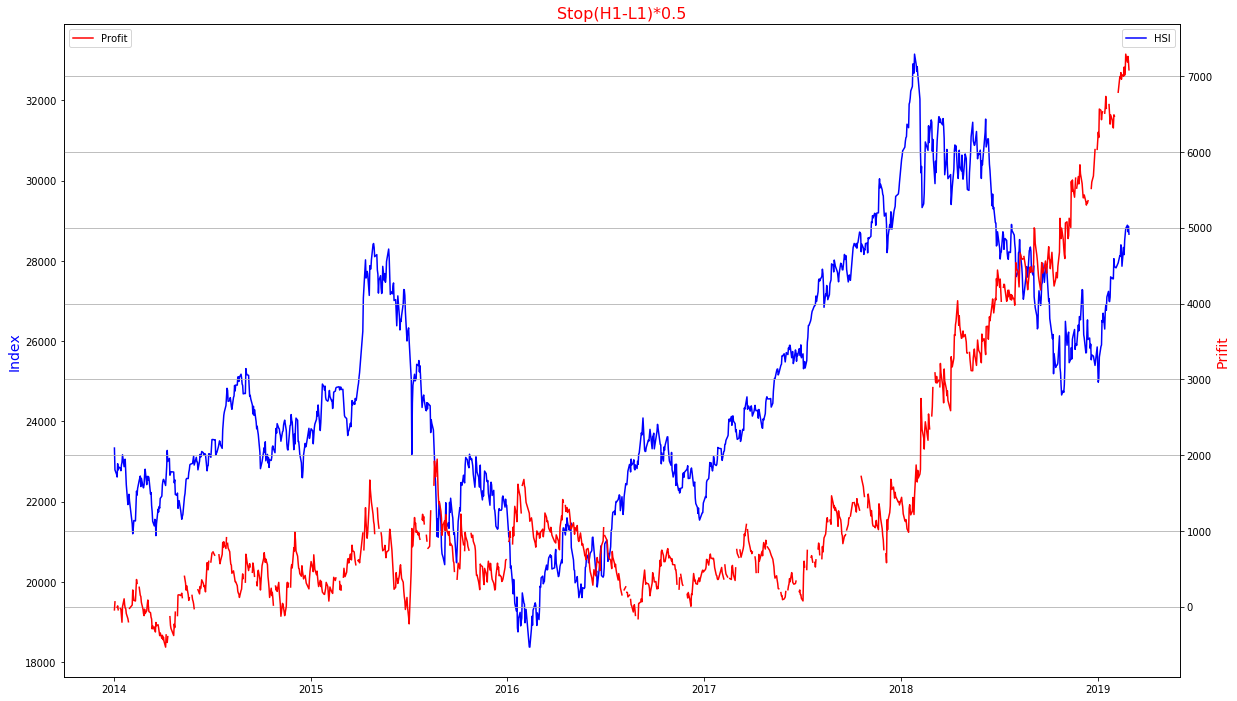

In [611]:
# fig, ax = plt.subplots(）
f1=plt.figure(figsize=(20,12))

ax=f1.add_subplot(111)
# ax.plot(DFtest.index,DFtest['Diff'].cumsum(),C='G')
ax.plot(F1.index,F1['Close'],c='B', label='HSI')
ax.set_ylabel("Index",color='B',size=14)
ax.legend(loc='upper right')
ax1=ax.twinx()

ax1.plot(F1.index,F1['Diff_S'].cumsum(),C='R', label='Profit')
ax1.set_ylabel("Prifit",color='R',size=14)
ax1.legend(loc='upper left')
ax.set_title("Stop(H1-L1)*0.5",size=16,Color='r')
plt.grid(True)
# f1.savefig("HL3.jpg")

plt.show()
plt.close()

In [430]:
col1=['LiM','Close']
a=F1[F1.Close>F1.Open][col1].groupby('LiM')
a.get_group(0).resample('Y').count()
# F1[['LiM']][F1.Close>F1.Open].resample('Y').count()

,LiM,Close
Date,,
2014-12-31,94,94
2015-12-31,82,82
2016-12-31,100,100
2017-12-31,107,107
2018-12-31,91,91
2019-12-31,18,18


In [28]:
T1=DFi[DFi['Close']-DFi['Open']>0]
print(T1.shape,492/640)
T1.groupby('LiM').agg('count')

(640, 11) 0.76875


,Date,Open,High,Low,Close,Hindex,Lindex,HiH,LiH,HiM
LiM,,,,,,,,,,
0,492,492,492,492,492,492,492,492,492,492
1,76,76,76,76,76,76,76,76,76,76
2,19,19,19,19,19,19,19,19,19,19
3,5,5,5,5,5,5,5,5,5,5
4,29,29,29,29,29,29,29,29,29,29
5,12,12,12,12,12,12,12,12,12,12
6,7,7,7,7,7,7,7,7,7,7


In [31]:
T2=DFi[DFi['Close']-DFi['Open']<0]
print(T2.shape,498/625)
T2.groupby('HiM').agg('count')


(625, 11) 0.7968


,Date,Open,High,Low,Close,Hindex,Lindex,HiH,LiH,LiM
HiM,,,,,,,,,,
0,498,498,498,498,498,498,498,498,498,498
1,58,58,58,58,58,58,58,58,58,58
2,21,21,21,21,21,21,21,21,21,21
3,9,9,9,9,9,9,9,9,9,9
4,23,23,23,23,23,23,23,23,23,23
5,12,12,12,12,12,12,12,12,12,12
6,4,4,4,4,4,4,4,4,4,4


In [80]:
np.pi

3.141592653589793

In [ ]:
#  涨的话 71% 最低点发生在 9点左右
#  跌的话 73% 最高点出现在9点左右

In [48]:
df2=df1.head()
# df2.datetime.apply(lambda x:x.time())
time1=dt.time(9,15,0)
time2=dt.time(16,30,0)
tm1=df1[df1['datetime'].dt.time==time1]
tm2=df1[df1['datetime'].dt.time==time1]
# df2.datetime.dt.time
print(tm1.shape,tm2.shape)


(531, 6) (531, 6)


In [346]:
DFtest.columns

Index(['Action', 'Close', 'Diff', 'Diff_S', 'High', 'High1', 'High2', 'Low',
       'Low1', 'Low2', 'Open', 'Price', 'Ref', 'StopPrice', 'Diff_L', 'Diff_H',
       'Diff_W'],
      dtype='object')

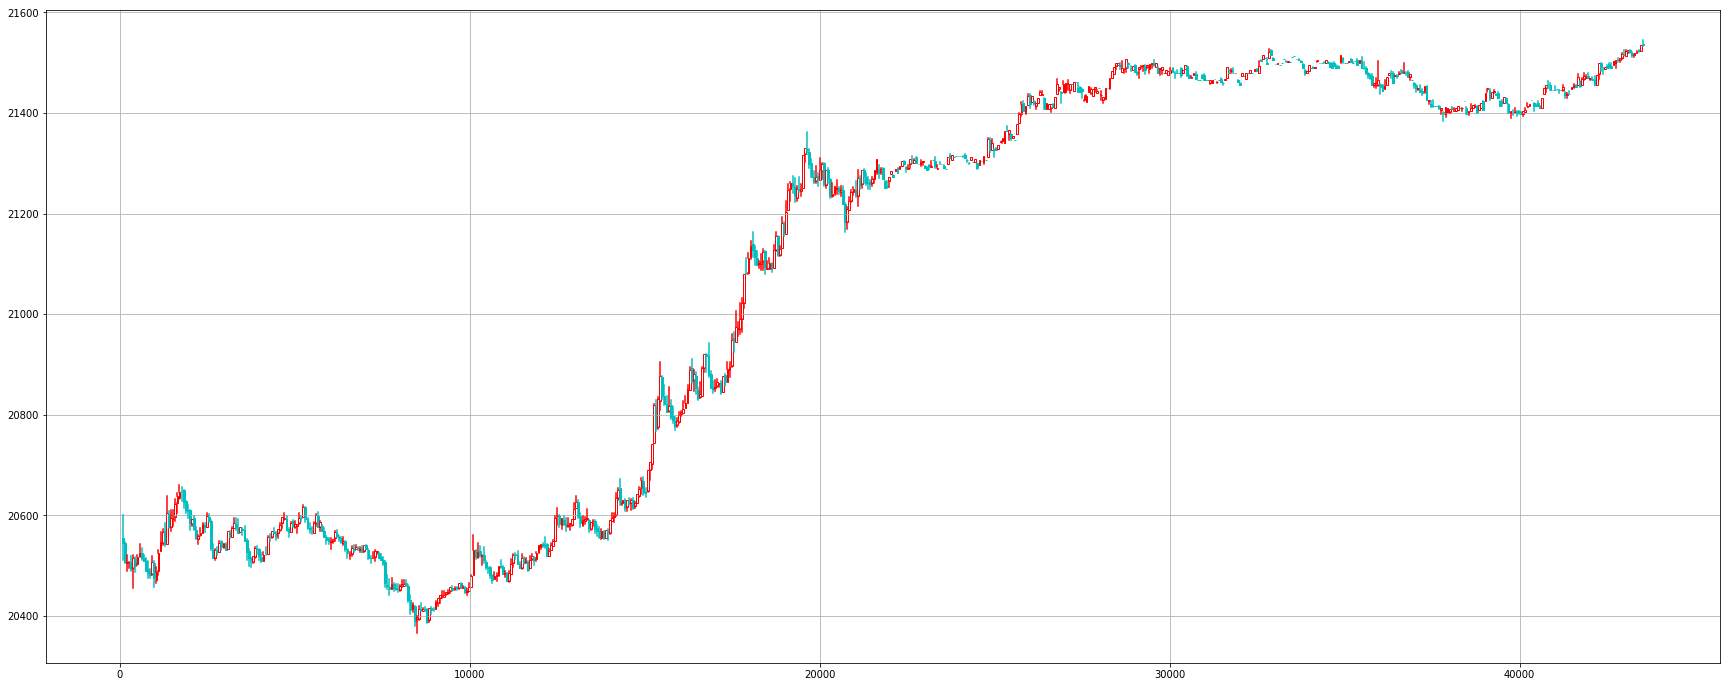

In [221]:
date='2015-09-08'

aa=df1[date]
DrawKK(aa)

In [183]:
def DrawKK(aa):
    fig =plt.figure(figsize=(30, 12),facecolor='w')

    ax =fig.add_subplot(111)
#     ax=plt.gca()
    k_width = 50
    k_diff = 10
    kline = k_width + k_diff
    d=0
    rows=len(aa)
    for i in aa.iterrows():
        d=d+1
        x = d * kline
        O = i[1]['open']
        C = i[1]['close']
        L = i[1]['low']
        H = i[1]['high']
        hh = abs(C - O)
        x1 = x + k_width / 2
        if C > O:
            a = False
            y = O
            cc = 'R'
            # 上影线 下影线
            line1 = Line2D((x1, x1), (C, H), color=cc)
            line2 = Line2D((x1, x1), (O, L), color=cc)

            ax.add_line(line1)
            ax.add_line(line2)
        else:
            a = True
            y = C
            cc = 'C'
            # 影线
            line = Line2D((x1, x1), (L, H), color=cc)
            ax.add_line(line)
        hh = abs(C - O)

        # K线实体
        rec = Rectangle((x, y), k_width, hh, fill=a, color=cc)
        ax.add_patch(rec)

    # plt.plot(aa.index*kline + k_width / 2,aa['ma60'],c='r')
    # plt.plot(aa.index*kline + k_width / 2,aa['ma30'],c='b')
    ax.grid()
    ax.autoscale(tight=False)
    ax.autoscale_view()
    # title="%s--%s,Corr:%.3f" %(time1,time2,corr)
    # ax.set_title(title, fontsize=20, color='r')
    # if isSave:
    #     file="res/%s%d_%.7s.jpg"%(preF,self.Amount,time1)
    #     fig.savefig(file)
    #     self.FIG=fig
    #     fig.clear()
    #     plt.close(fig)